<a href="https://colab.research.google.com/github/hochenri/projects-portfolio/blob/main/Denoising_Generator_Artist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising Generator
In this demonstration I will try to generate images of landscapes from pure noise. I will train an autoencoder to denoise images of landscapes and than use it to progressively denoise images generated with purely random noise.

In [1]:
import numpy as np
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
import datetime
import matplotlib.pyplot as plt
import random
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# Data preparation
The function below loads a preprocessed image dataset containing 1024px x 1024px images of landscapes.

It takes the file path containing the images, the image size and the dataset batchsize in input.

I have decided to have a maximum image size of 1024px by 1024px. However, if a lower image size is passed to the function, it will reshape all the images to the given size.

It then converts the image pixels type to uint8 to float32 to allow float values and training the model.

Finally, it rescales the image pixels from [0, 255] to [0, 1].

In [8]:
def load_data(path, imsize):
    ims = np.load(path)
    ims_resized = []
    if imsize[0] < ims[0].shape[0] or imsize[1] < ims[1].shape[1]:
        for im in ims:
            ims_resized.append(tf.image.resize(
                im, (imsize[0], imsize[1]), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
            ))
    ims = np.array(ims_resized).astype('float32')
    ims = ims / 255.0
    return ims

# The denoiser
The following function generates an autoencoder model which will be used to denoise images. It downsamples an image while learning its features with `Conv2D` and `MaxPooling2D` layers, then it upsamples it back up to its original size while reproducing the denoised image with `Conv2DTranspose` layers.

Parameters:
* sampling steps used to downsample and upsample the images (`steps`)
* number of filters for each convolutional and transpose convolutional layer (`filters`)
* input (and output) shape of the image (`inshape`)
* number of channels of the image (1 for grayscale images, 3 for rgb images) (`channels`)

In [4]:
def make_denoiser(steps, filters, inshape, channels=3):
    model = tf.keras.models.Sequential()
    model.add(layers.InputLayer(input_shape=inshape))
    # ENCODER
    for i in range(steps):
        model.add(layers.Conv2D(
            filters,
            kernel_size=3,
            strides=1,
            activation='relu',
            padding='same'
        ))
        model.add(layers.MaxPooling2D(
            strides=2,
            padding='same'
        ))

    # DECODER
    for i in range(steps):
        model.add(
            layers.Conv2DTranspose(
                filters,
                kernel_size=5,
                strides=2,
                activation='relu',
                padding='same'
            )
        )
    model.add(
        layers.Conv2DTranspose(
            channels,
            kernel_size=3,
            strides=1,
            padding='same',
            activation='sigmoid'
        )
    )

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy' # mse, mae or binary_crossentropy
    )
    return model

# Parameters definition

In [5]:
# image
channels = 3
imsize = 2**9
# model
sampling_steps= 7
input_shape = [imsize, imsize, channels]
filters = 64
processing_steps = 10
# training
epochs = 50
batch_size = 1
new_model = True # True to start from a new model, False to load a pretrained model
training = True # True to train the model, False to skip training
tpu = True # True if using Google Colab TPU (Tensor Processing Unit)
# file system
modelname = f'denoiser_{filters}filts_{imsize}px_{sampling_steps}steps.h5'
path = 'drive/My Drive/Colab Notebooks/'
picsfile = os.path.join(path, 'Datasets', 'imgs.npy')
modelfile = os.path.join(path, 'Models', modelname)

# Model setup

In [6]:
if tpu:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
    tf.config.experimental_connect_to_cluster(resolver)
    # This is the TPU initialization code that has to be at the beginning.
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    with strategy.scope():
        if new_model:
            denoiser = make_denoiser(
                sampling_steps,
                filters,
                input_shape,
                channels=channels,
            )
        else:
            denoiser = tf.keras.models.load_model(modelfile)
else:
    if new_model:
        denoiser = make_denoiser(
            sampling_steps,
            filters,
            input_shape,
            channels=channels,
        )
    else:
        denoiser = tf.keras.models.load_model(modelfile)

# Data preparation

In [9]:
if training:
    dataset = load_data(picsfile, input_shape)
    alpha = 1.0 / processing_steps
    noisy_data = np.clip(
        alpha * tf.random.normal(dataset.shape) + (1-alpha) * dataset,
        0, 1
    )

Original image

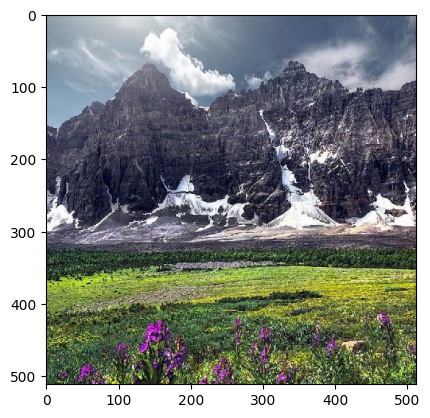

In [10]:
if training:
    img = random.choice(dataset)
    plt.imshow(img)
    plt.show()

Noisy image

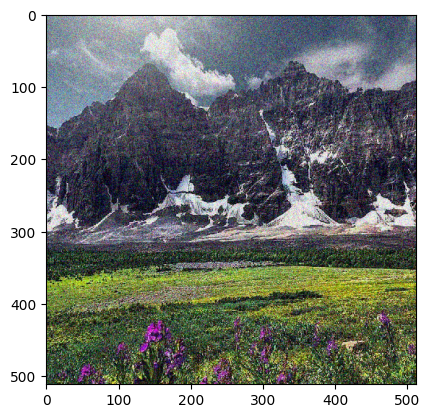

In [11]:
if training:
    noisy_img = np.clip(
        alpha * tf.random.normal(img.shape) + (1-alpha) * img,
        0, 1
    )
    plt.imshow(noisy_img)
    plt.show()

# Model training

In [14]:
if training:
    denoiser.fit(
        noisy_data,
        dataset,
        batch_size=batch_size,
        epochs=epochs
    )
    denoiser.save(modelfile)

Epoch 1/50
71/71 [==============================] - 9s 124ms/step - loss: 0.5687
Epoch 2/50
71/71 [==============================] - 9s 124ms/step - loss: 0.5695
Epoch 3/50
71/71 [==============================] - 9s 125ms/step - loss: 0.5673
Epoch 4/50
71/71 [==============================] - 9s 123ms/step - loss: 0.5670
Epoch 5/50
71/71 [==============================] - 9s 124ms/step - loss: 0.5655
Epoch 6/50
71/71 [==============================] - 9s 124ms/step - loss: 0.5638
Epoch 7/50
71/71 [==============================] - 9s 124ms/step - loss: 0.5634
Epoch 8/50
71/71 [==============================] - 9s 124ms/step - loss: 0.5624
Epoch 9/50
71/71 [==============================] - 9s 124ms/step - loss: 0.5625
Epoch 10/50
71/71 [==============================] - 9s 123ms/step - loss: 0.5622
Epoch 11/50
71/71 [==============================] - 9s 124ms/step - loss: 0.5622
Epoch 12/50
71/71 [==============================] - 9s 123ms/step - loss: 0.5617
Epoch 13/50
71/71 [======

# New image generation

1/1 [==============================] - 1s 985ms/step


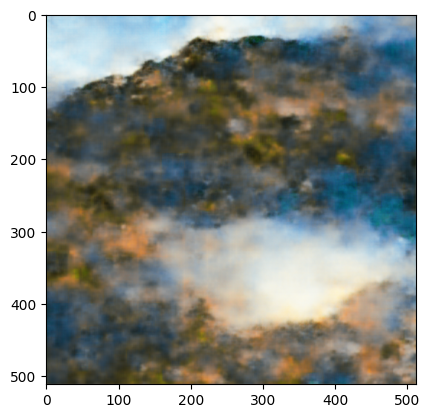

In [15]:
img = tf.random.normal(shape=(1, imsize, imsize, channels))
for i in range(processing_steps):
    img = denoiser.predict(img)
img = (255.0 * img).astype('uint8')
img = img[0]
img = Image.fromarray(img)
fileout = os.path.join(path, f'output{datetime.datetime.now()}.jpg')
img.save(fileout)
plt.imshow(img)
plt.show()